Classes:
- 1: Decrease
- 2: Equal
- 3: Increase

# Import libraries and load data

In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, log_loss
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance
from scipy.stats import uniform, randint
from sklearn import tree
from lightgbm import LGBMClassifier

In [2]:

db_params = {
    "host": "localhost",
    "port": "5432",
    "database": "vnstockdw",
    "user": "postgres",
    "password": "postgres"
}

table_name = "stock_history"
table_schema = "public"

conn = psycopg2.connect(**db_params)

cur = conn.cursor()

cur.execute(f"SELECT * FROM {table_name}")

rows = cur.fetchall()

col_names = [desc[0] for desc in cur.description]

stock_df = pd.DataFrame(rows, columns=col_names)

cur.close()
conn.close()

### Data columns

In [3]:
stock_df.columns

Index(['created_at', 'updated_at', 'status', 'symbol', 'open', 'high', 'low',
       'close', 'volume', 'date', 'price_change_to_1_day(s)_ago',
       'price_change_to_2_day(s)_ago', 'price_change_to_3_day(s)_ago',
       'volume_change_to_1_day(s)_ago', 'volume_change_to_2_day(s)_ago',
       'volume_change_to_3_day(s)_ago', 'price_difference',
       'median_volume_3_day(s)_periods', 'std_volume_3_day(s)_periods',
       'median_price_change_3_day(s)_periods',
       'std_price_change_3_day(s)_periods',
       'median_volume_change_3_day(s)_periods',
       'std_volume_change_3_day(s)_periods', 'sma_3_days', 'sma_5_days',
       'wma_3_days', 'wma_5_days', 'ema_3_days', 'ema_5_days',
       'bool_sma_3_days', 'bool_sma_5_days', 'bool_wma_3_days',
       'bool_wma_5_days', 'bool_ema_3_days', 'bool_ema_5_days',
       'macd_of_ema3_and_ema5', '%k_3_days', '%k_5_days', '%d_3_days',
       '%d_5_days', 'rsi_3_days', 'rsi_5_days', 'williams_%r_3_days',
       'ad_3_days', 'cci_3_days', 'b

### Data shape

In [4]:
stock_df.shape

(177796, 60)

# Label Creation

In [5]:
stock_df.date.value_counts()

date
2023-08-18    1111
2023-09-08    1107
2023-08-11    1103
2023-06-23    1102
2023-07-28    1100
              ... 
2024-01-15      63
2024-01-10      63
2024-01-09      63
2024-01-17      62
2024-01-16      62
Name: count, Length: 195, dtype: int64

In [6]:
stock_df.head()

,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_%d_5_days,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days
0,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7820.0,7640.0,7640.0,430400.0,2023-05-04,...,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,NaN,NaN,1.0,0.011643,NaN,NaN,786100.0,0.500000,0.500000,0.500000
2,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7550.0,7910.0,7550.0,7820.0,1907900.0,2023-05-08,...,NaN,-1.0,1.0,0.011509,0.023018,0.0,1907900.0,0.333333,0.333333,0.333333
3,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7820.0,8090.0,7820.0,8000.0,1686400.0,2023-05-09,...,NaN,-1.0,1.0,0.022500,0.033750,0.0,1686400.0,0.250000,0.500000,0.333333
4,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8000.0,1074000.0,2023-05-10,...,1.0,-1.0,1.0,0.000000,0.022500,0.0,0.0,0.200000,0.400000,0.300000


In [7]:
grouped_df = stock_df.groupby(['date', 'symbol'])
print("Columns with different dates and symbol:", len(grouped_df))

Columns with different dates and symbol: 177796


In [8]:
stock_df['date'] = pd.to_datetime(stock_df['date'])

stock_df['label'] = None

stock_df['future_date'] = stock_df['date'] + pd.DateOffset(days=3)

merged_df = stock_df.merge(stock_df, how='left', left_on=['symbol', 'future_date'], right_on=['symbol', 'date'], suffixes=('', '_future'))

merged_df['price_difference'] = merged_df['close_future'] - merged_df['close']
merged_df['label'] = np.where(merged_df['price_difference'] > 0, 2, 
                              np.where(merged_df['price_difference'] < 0, 0, 1))

merged_df.loc[merged_df['close_future'].isnull(), 'label'] = None
# merged_df.loc[:, ["symbol", "date", "close", "future_date", "close_future"]]

stock_df['label'] = merged_df['label']

stock_df.drop(['future_date'], axis=1, inplace=True)

stock_df.head()

,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label
0,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7820.0,7640.0,7640.0,430400.0,2023-05-04,...,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,NaN,1.0,0.011643,NaN,NaN,786100.0,0.500000,0.500000,0.500000,2.0
2,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7550.0,7910.0,7550.0,7820.0,1907900.0,2023-05-08,...,-1.0,1.0,0.011509,0.023018,0.0,1907900.0,0.333333,0.333333,0.333333,2.0
3,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7820.0,8090.0,7820.0,8000.0,1686400.0,2023-05-09,...,-1.0,1.0,0.022500,0.033750,0.0,1686400.0,0.250000,0.500000,0.333333,2.0
4,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8000.0,1074000.0,2023-05-10,...,-1.0,1.0,0.000000,0.022500,0.0,0.0,0.200000,0.400000,0.300000,NaN


In [9]:
# stock_df['date'] = pd.to_datetime(stock_df['date'])

# stock_df['label'] = None

# for index, row in stock_df.iterrows():
#     future_rows = stock_df[(stock_df['date'] == row['date'] + pd.DateOffset(days=3)) & (stock_df['symbol'] == row['symbol'])]
#     if not future_rows.empty:
#         future_row = future_rows.iloc[0] 
#         price_difference = future_row['close'] - row['close']
#         if price_difference > 0:
#             stock_df.at[index, 'label'] = 1
#         else:
#             stock_df.at[index, 'label'] = 0

# stock_df.head()

In [10]:
# stock_df.to_csv('stock_data_transformed.csv', index=False)

In [11]:
# stock_df = pd.read_csv('stock_data_transformed.csv')

Check transformation integrity

In [9]:
sample_rows = stock_df.sample(5) 

for index, sample_row in sample_rows.iterrows():
    symbol = sample_row['symbol']
    sample_date = sample_row['date']
    close = sample_row['close']
    label = sample_row['label']
    
    print(f"Sample Date: {sample_date}, Symbol: {symbol}, Close: {close}, Label: {label}")

    future_records = stock_df[(stock_df['date'] == sample_date + pd.DateOffset(days=3)) & (stock_df['symbol'] == symbol)]
    print("Records 3 Days Later:")
    print(future_records[['symbol', 'date', 'close', 'label']].to_string(index=False, header=False))
    print()


Sample Date: 2024-01-30 00:00:00, Symbol: NBW, Close: 23800.0, Label: nan
Records 3 Days Later:
Empty DataFrame
Columns: [symbol, date, close, label]
Index: []

Sample Date: 2023-10-30 00:00:00, Symbol: TTA, Close: 8189.0, Label: 0.0
Records 3 Days Later:
TTA 2023-11-02 8140.0 NaN

Sample Date: 2023-10-26 00:00:00, Symbol: PXT, Close: 3700.0, Label: nan
Records 3 Days Later:
Empty DataFrame
Columns: [symbol, date, close, label]
Index: []

Sample Date: 2023-09-12 00:00:00, Symbol: QTC, Close: 12150.0, Label: nan
Records 3 Days Later:
Empty DataFrame
Columns: [symbol, date, close, label]
Index: []

Sample Date: 2023-06-16 00:00:00, Symbol: HD8, Close: 9110.0, Label: 0.0
Records 3 Days Later:
HD8 2023-06-19 9020.0 2.0



In [10]:
filtered_df = stock_df.dropna(subset=['label'])
filtered_df['label'] = filtered_df['label'].astype(int)
print(filtered_df.shape)
filtered_df.head()

(90079, 61)


/var/folders/x1/372sp1hn2fs8wfj7nl_xj3s80000gn/T/ipykernel_71809/572843370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['label'].astype(int)


,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,NaN,1.0,0.011643,NaN,NaN,786100.0,0.500000,0.500000,0.500000,2
2,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7550.0,7910.0,7550.0,7820.0,1907900.0,2023-05-08,...,-1.0,1.0,0.011509,0.023018,0.0,1907900.0,0.333333,0.333333,0.333333,2
3,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7820.0,8090.0,7820.0,8000.0,1686400.0,2023-05-09,...,-1.0,1.0,0.022500,0.033750,0.0,1686400.0,0.250000,0.500000,0.333333,2
6,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8090.0,1052500.0,2023-05-12,...,1.0,1.0,0.011125,0.011125,0.0,1052500.0,0.166667,0.500000,0.300000,2
7,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8090.0,8640.0,8000.0,8360.0,4371800.0,2023-05-15,...,-1.0,-1.0,0.032297,0.043062,0.0,4371800.0,0.166667,0.500000,0.300000,0


# EDA?

In [11]:
num_negative = filtered_df[filtered_df["label"] == 0].shape[0]
print("Numbers of negative:", num_negative)
num_equal = filtered_df[filtered_df["label"] == 1].shape[0]
print("Numbers of equal:", num_equal)
num_positive = filtered_df[filtered_df["label"] == 2].shape[0]
print("Numbers of positive:", num_positive)

Numbers of negative: 38126
Numbers of equal: 11970
Numbers of positive: 39983


In [12]:
filtered_df.label.value_counts()

label
2    39983
0    38126
1    11970
Name: count, dtype: int64

In [13]:
grouped_df = filtered_df.groupby(['date', 'symbol'])
print("Columns with similar dates and symbol:", len(grouped_df))

Columns with similar dates and symbol: 90079


# Models Training

## Split data

In [14]:
X = filtered_df.drop(columns=['label', 'created_at', 'updated_at', 'status', 'symbol', 'date'], axis=1)
y = filtered_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((72063, 55), (18016, 55), (72063,), (18016,))

In [15]:
#For models that cannot take -1
y_mod_train = y_train.replace(0, -1)
y_mod_test = y_test.replace(0, -1)

In [16]:
y_test.value_counts()

label
2    7997
0    7625
1    2394
Name: count, dtype: int64

## Benchmark models
### Dummy model

In [17]:
dummy_clf = DummyClassifier(strategy = 'stratified').fit(X_train, y_train)

dummy_score = dummy_clf.score(X_test, y_test)
print("Dummy Classifier Test Accuracy:", dummy_score)

Dummy Classifier Test Accuracy: 0.3935945825932504


In [19]:
y_dummy_predictions = dummy_clf.predict(X_test)
print(classification_report(y_test, y_dummy_predictions, target_names=['decrease', 'equal', 'increase']))

              precision    recall  f1-score   support

    decrease       0.42      0.42      0.42      7625
       equal       0.13      0.13      0.13      2394
    increase       0.44      0.44      0.44      7997

    accuracy                           0.39     18016
   macro avg       0.33      0.33      0.33     18016
weighted avg       0.39      0.39      0.39     18016



In [24]:
def calculate_auc_scores(y_test, y_dummy_predictions_proba):
    classes = np.unique(y_test)
    auc_scores = []
    for class_index in classes:
        y_true_class = np.where(y_test == class_index, 1, 0)
        y_pred_class = y_dummy_predictions_proba[:, class_index]
        auc_class = roc_auc_score(y_true_class, y_pred_class)
        auc_scores.append(auc_class)

    for class_index, auc_class in enumerate(auc_scores):
        print(f"Class {classes[class_index]} AUC: {auc_class}")

    roc_auc_macro = roc_auc_score(y_test, y_dummy_predictions_proba, multi_class='ovr', average='macro')
    print("Multi-class ROC AUC Score (macro average):", roc_auc_macro)

    roc_auc_weighted = roc_auc_score(y_test, y_dummy_predictions_proba, multi_class='ovr', average='weighted')
    print("Multi-class ROC AUC Score (weighted average):", roc_auc_weighted)

    return auc_scores, roc_auc_macro, roc_auc_weighted

y_dummy_predictions_proba = dummy_clf.predict_proba(X_test)
auc_scores, roc_auc_macro, roc_auc_weighted = calculate_auc_scores(y_test, y_dummy_predictions_proba)

Class 0 AUC: 0.5069550351738816
Class 1 AUC: 0.49761312233770105
Class 2 AUC: 0.5075339723101823
Multi-class ROC AUC Score (macro average): 0.5040340432739217
Multi-class ROC AUC Score (weighted average): 0.5059706446848263


In [29]:
def print_model_evaluation_metrics(clf, X_train, y_train, X_test, y_test):
    # Train Accuracy
    train_accuracy = clf.score(X_train, y_train)
    print("Train Accuracy: {:.3f}".format(train_accuracy))

    # Test Accuracy
    test_accuracy = clf.score(X_test, y_test)
    print("Test Accuracy: {:.3f}".format(test_accuracy))

    y_test_predicted_proba = clf.predict_proba(X_test)
    calculate_auc_scores(y_test, y_dummy_predictions_proba)

    # Log Loss
    y_test_predicted_proba = clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_predicted_proba)
    print('Test Log Loss: {:.3f}'.format(test_log_loss))

    # Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_dummy_predictions, target_names=['decrease', 'equal', 'increase']))

In [32]:
def cross_val_scores(tree_clf, X, y, cv=5):
    scoring_metrics = ['neg_log_loss', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
    
    cv_results = {'Metric': [], 'Cross-validated Scores': [], 'Mean Cross-validated Score': []}
    
    for metric in scoring_metrics:
        cv_scores = cross_val_score(tree_clf, X, y, cv=cv, scoring=metric)
        cv_results['Metric'].append(metric.capitalize())
        cv_results['Cross-validated Scores'].append(cv_scores)
        mean_score = cv_scores.mean()
        cv_results['Mean Cross-validated Score'].append('{:.3f}'.format(mean_score))
            
    df = pd.DataFrame(cv_results)
    
    return df

## XGBoost

In [30]:
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0)
xgb_clf.fit(X_train, y_train)
print_model_evaluation_metrics(xgb_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.685
Test Accuracy: 0.523
Class 0 AUC: 0.5069550351738816
Class 1 AUC: 0.49761312233770105
Class 2 AUC: 0.5075339723101823
Multi-class ROC AUC Score (macro average): 0.5040340432739217
Multi-class ROC AUC Score (weighted average): 0.5059706446848263
Test Log Loss: 0.936
Classification Report:
              precision    recall  f1-score   support

    decrease       0.42      0.42      0.42      7625
       equal       0.13      0.13      0.13      2394
    increase       0.44      0.44      0.44      7997

    accuracy                           0.39     18016
   macro avg       0.33      0.33      0.33     18016
weighted avg       0.39      0.39      0.39     18016



In [33]:
cv_scores_df = cross_val_scores(xgb_clf, X, y)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.9437270364770043, -0.9417779896692005, -0....",-0.942
1,Accuracy,"[0.5177619893428064, 0.5153752220248667, 0.518...",0.517
2,Precision_macro,"[0.47456986191789463, 0.4746470148340938, 0.47...",0.477
3,Recall_macro,"[0.4154215538643893, 0.4112512987687455, 0.423...",0.417
4,F1_macro,"[0.40970912008762456, 0.40348789499523247, 0.4...",0.413
5,Roc_auc_ovr,"[0.649748761758495, 0.6520950036295186, 0.6552...",0.652


In [34]:
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0)
xgb_clf.fit(X_train, y_train)
print_model_evaluation_metrics(xgb_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.685
Test Accuracy: 0.523
Class 0 AUC: 0.5069550351738816
Class 1 AUC: 0.49761312233770105
Class 2 AUC: 0.5075339723101823
Multi-class ROC AUC Score (macro average): 0.5040340432739217
Multi-class ROC AUC Score (weighted average): 0.5059706446848263
Test Log Loss: 0.936
Classification Report:
              precision    recall  f1-score   support

    decrease       0.42      0.42      0.42      7625
       equal       0.13      0.13      0.13      2394
    increase       0.44      0.44      0.44      7997

    accuracy                           0.39     18016
   macro avg       0.33      0.33      0.33     18016
weighted avg       0.39      0.39      0.39     18016



In [35]:
cv_scores_df = cross_val_scores(xgb_clf, X, y)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.9437270364770043, -0.9417779896692005, -0....",-0.942
1,Accuracy,"[0.5177619893428064, 0.5153752220248667, 0.518...",0.517
2,Precision_macro,"[0.47456986191789463, 0.4746470148340938, 0.47...",0.477
3,Recall_macro,"[0.4154215538643893, 0.4112512987687455, 0.423...",0.417
4,F1_macro,"[0.40970912008762456, 0.40348789499523247, 0.4...",0.413
5,Roc_auc_ovr,"[0.649748761758495, 0.6520950036295186, 0.6552...",0.652


In [ ]:
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0)
xgb_clf.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
print_model_evaluation_metrics(xgb_clf, X_train, y_train, X_test, y_test)

In [ ]:
params = {
    "gamma": uniform(0, 0.9),
    "learning_rate": uniform(0.01, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": [20, 50, 100, 150], # default 100
}

search = RandomizedSearchCV(xgb_clf, param_distributions=params, random_state=0, n_iter=200, cv=5, scoring='roc_auc')

search.fit(X, y)

print(search.best_estimator_)
print(search.best_params_)
print(search.best_score_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.44141292775581037, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07822438839199697,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)
{'gamma': 0.44141292775581037, 'learning_rate': 0.07822438839199697, 'max_depth': 5, 'n_estimators': 150}
0.6324372674104092


In [ ]:
xgb_clf = search.best_estimator_
# params = {
#     'gamma': 0.44141292775581037, 
#     'learning_rate': 0.13333333333333333, 
#     'max_depth': 5, 
#     'n_estimators': 150,
# }

# xgb_clf = XGBClassifier(**params, eval_metric='auc')

xgb_clf.fit(X_train, y_train)

[0]	validation_0-auc:0.59636
[1]	validation_0-auc:0.60268
[2]	validation_0-auc:0.60622
[3]	validation_0-auc:0.60898
[4]	validation_0-auc:0.61174
[5]	validation_0-auc:0.61420
[6]	validation_0-auc:0.61643
[7]	validation_0-auc:0.61774
[8]	validation_0-auc:0.61894
[9]	validation_0-auc:0.61911
[10]	validation_0-auc:0.62016
[11]	validation_0-auc:0.62129
[12]	validation_0-auc:0.62166
[13]	validation_0-auc:0.62195
[14]	validation_0-auc:0.62258
[15]	validation_0-auc:0.62367
[16]	validation_0-auc:0.62393
[17]	validation_0-auc:0.62460
[18]	validation_0-auc:0.62512
[19]	validation_0-auc:0.62548
[20]	validation_0-auc:0.62617
[21]	validation_0-auc:0.62629
[22]	validation_0-auc:0.62654
[23]	validation_0-auc:0.62681
[24]	validation_0-auc:0.62771
[25]	validation_0-auc:0.62801
[26]	validation_0-auc:0.62845
[27]	validation_0-auc:0.62899
[28]	validation_0-auc:0.62939
[29]	validation_0-auc:0.62983
[30]	validation_0-auc:0.62971
[31]	validation_0-auc:0.63014
[32]	validation_0-auc:0.62978
[33]	validation_0-au

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.44141292775581037, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13333333333333333,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
print_model_evaluation_metrics(xgb_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.680
Test Accuracy: 0.611
Train AUC: 0.660
Test AUC: 0.589
Test Log Loss: 0.656
Classification Report:
              precision    recall  f1-score   support

       not 1       0.62      0.78      0.69     12524
           1       0.59      0.40      0.47      9996

    accuracy                           0.61     22520
   macro avg       0.61      0.59      0.58     22520
weighted avg       0.61      0.61      0.59     22520



In [ ]:
cv_scores_df = cross_val_scores(xgb_clf, X, y)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.659334347641136, -0.659069530116427, -0.65...",-0.659
1,Accuracy,"[0.6062388987566607, 0.6041851687388987, 0.610...",0.605
2,Precision,"[0.5852691218130311, 0.575991575991576, 0.5916...",0.583
3,Recall,"[0.387520320120045, 0.41040390146304867, 0.397...",0.389
4,F1,"[0.4662955160999097, 0.4792990142387733, 0.475...",0.467
5,Roc_auc,"[0.6317248135133218, 0.6310906177100573, 0.637...",0.632


Learning Rate with Closest AUC and Log Loss: 0.13333333333333333


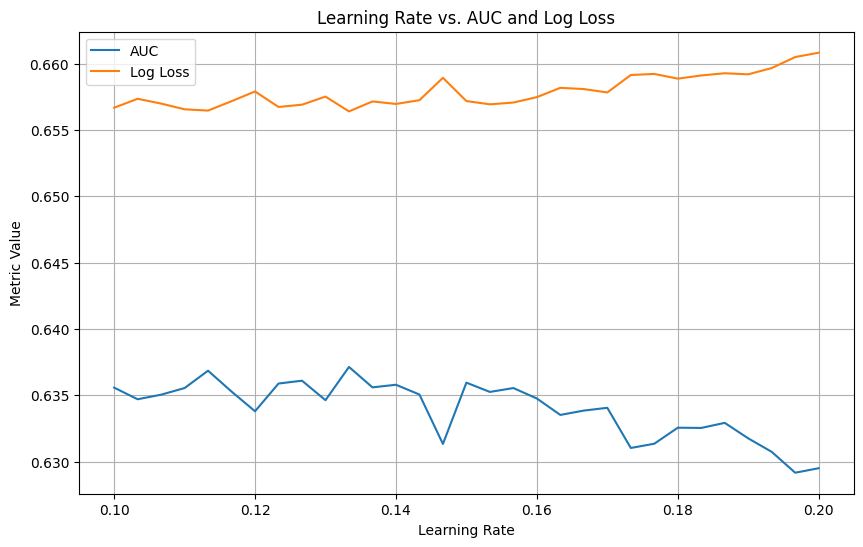

In [ ]:
learning_rates = np.linspace(0.1, 0.2, 31)

base_params = {
    'gamma': 0.44141292775581037, 
    'max_depth': 5, 
    'n_estimators': 150,
    'eval_metric': 'auc'
}

best_lr = None
min_diff = float('inf')
auc_values = []
log_loss_values = []

for lr in learning_rates:
    params = base_params.copy()
    params['learning_rate'] = lr
    
    xgb_clf = XGBClassifier(**params)
    xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    y_pred_proba = xgb_clf.predict_proba(X_test)
    
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    auc_values.append(auc)

    logloss = log_loss(y_test, y_pred_proba)
    log_loss_values.append(logloss)
    
    diff = abs(auc - logloss)
    
    if diff < min_diff:
        min_diff = diff
        best_lr = lr

print("Learning Rate with Closest AUC and Log Loss:", best_lr)

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, auc_values, label='AUC')
plt.plot(learning_rates, log_loss_values, label='Log Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Metric Value')
plt.title('Learning Rate vs. AUC and Log Loss')
plt.legend()
plt.grid(True)
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

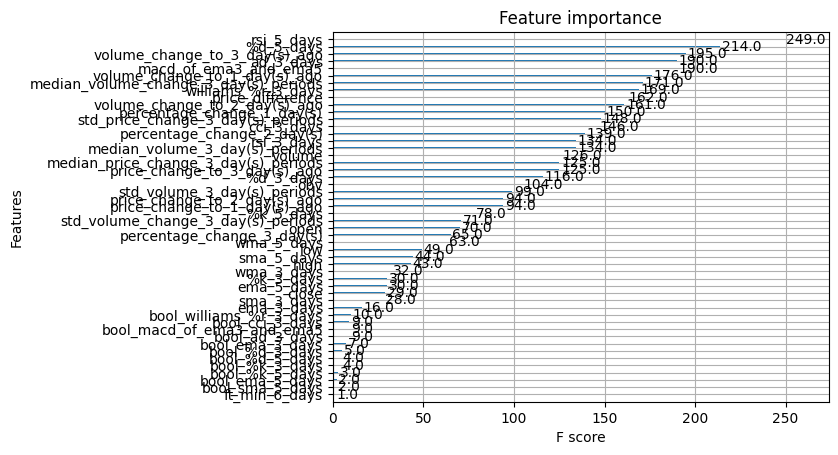

In [ ]:
plot_importance(xgb_clf)